<a href="https://colab.research.google.com/github/ggoddll99/24-2EURON-7th-DL/blob/Week_3/Week3_%EC%98%88%EC%8A%B5%EA%B3%BC%EC%A0%9C_%EA%B9%80%EB%8B%A4%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.2 합성곱 신경망 맛보기

**실습) fashion_mnist 데이터셋 - 합성곱 신경망 직접 구현**

- fashion_mnist : 토치비전에 내장된 예제 데이터로 운동화, 셔츠, 샌들 같은 작은 이미지의 모음이다. 기본 MNIST 데이터셋처럼 10가지로 분류될 수 있는 $28\times28$ 픽셀의 이미지 7만 개로 구성되어 있다. 훈련 데이터(train_images)는 0에서 255 사이의 값을 갖는 $28\times28$ 크기의 넘파이 배열이고, 레이블(정답) 데이터(train_labels)는 0에서 9까지 정수 값을 갖는 배열이다. 0에서 9까지 정수 값은 이미지의 클래스를 나타내는 레이블이다. 각 레이블과 클래스는 다음과 같다.
    - 0 : T-Shirt
    - 1 : Trouser
    - 2 : Pullover
    - 3 : Dress
    - 4 : Coat
    - 5 : Sandal
    - 6 : Shirt
    - 7 : Sneaker
    - 8 : Bag
    - 9 : Ankle Boot

In [ ]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms ## 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [ ]:
# CPU 혹은 GPU 장치 확인
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

일반적으로 하나의 GPU를 사용할 때는 다음 코드를 이용한다.
```
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=Net()
model.to(device)
```
사용하는 PC에서 다수의 GPU를 사용한다면 `nn.DataParallel`을 이용한다.
```
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=Net()
if torch.cuda.device_count()>1:
  model=nn.DataParallel(net)
model.to(device)
```
`nn.DataParallel`을 사용할 경우 배치 크기가 알아서 각 GPU로 분배되는 방식으로 작동한다. 따라서 GPU 수만큼 배치 크기도 늘려 주어야 한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# fashion_mnist 데이터셋 내려받기
train_dataset=torchvision.datasets.FashionMNIST('/content/drive/MyDrive/24-2/EURON/과제/Week3', download=True,
                                                transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=torchvision.datasets.FashionMNIST('/content/drive/MyDrive/24-2/EURON/과제/Week3', download=True,
                                                train=False, transform=transforms.Compose([transforms.ToTensor()]))
## 첫 번째 파라미터 : FashionMNIST를 내려받을 위치
## download : download를 True로 변경하면 첫 번째 파라미터의 위치에 해당 데이터셋이 있는지 확인한 후 내려받는다.
## transform : 이미지를 텐서(0~1)로 변경한다.

In [ ]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=100)

## torch.utils.data.DataLoader() : 원하는 크기의 배치 단위로 데이터를 불러오거나, 순서가 무작위로 섞이도록 할 수 있다.
## 첫 번째 파라미터 : 데이터를 불러올 데이터셋을 지정한다.
## batch_size : 데이터를 배치로 묶어 준다. batch_size=100으로 지정했기 때문에 100개 단위로 데이터를 묶어서 불러온다.

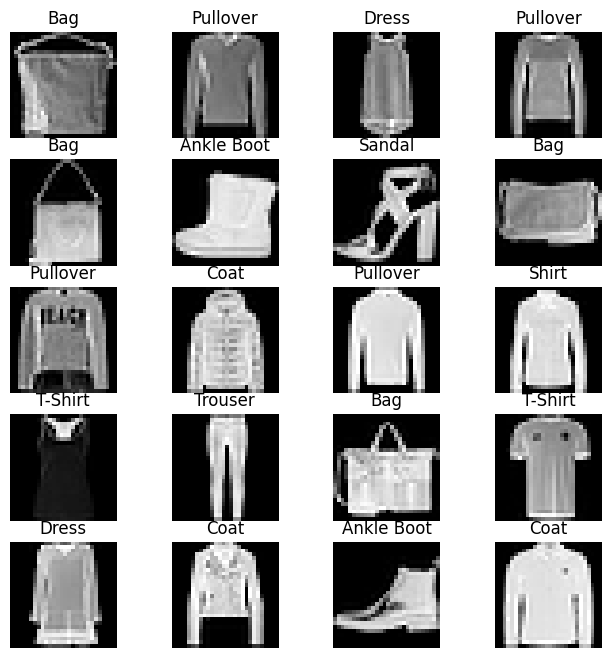

In [ ]:
# 분류에 사용될 클래스 정의
labels_map={0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
            5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'} ## 열 개의 클래스
fig=plt.figure(figsize=(8, 8)); ## 출력할 이미지의 가로세로 길이. inch
columns=4;
rows=5;
for i in range(1, columns*rows+1):
  img_xy=np.random.randint(len(train_dataset));
  ## np.random : 무작위로 데이터를 생성할 때 사용.
  ## np.random.rnadint() : 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용
  ## np.random.randint(len(train_dataset)) : 0~(train_dataset의 길이) 값을 갖는 분포에서 랜덤한 숫자 한 개를 생성하라.
  img=train_dataset[img_xy][0][0, :, :]
  ## train_dataset을 이용한 3차원 배열 생성
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() ## 20개의 이미지 데이터를 시각적으로 표현

20개의 이미지가 시각적으로 표현된다. 결과를 랜덤으로 보여 주기 때문에 책과 다를 수 있다.

In [ ]:
import numpy as np

np.random.randint(10) ## 0~10의 임의의 숫자 출력

8

In [ ]:
np.random.randint(1, 10) ## 1~9의 임의의 숫자 출력

8

In [ ]:
np.random.rand(8) ## 0~1 사이의 정규표준분포 난수를 행렬로 (1x8) 출력

array([0.75906887, 0.77096389, 0.00747754, 0.69740918, 0.00642564,
       0.80066083, 0.09017663, 0.66612392])

In [ ]:
np.random.rand(4, 2) ## 0~1 사이의 정규표준분포 난수를 행렬로 (4x2) 출력

array([[0.25864257, 0.70946159],
       [0.74545069, 0.6851124 ],
       [0.72310649, 0.43237632],
       [0.27137411, 0.92039405]])

In [ ]:
np.random.randn(8) ## 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (1x8) 출력

array([ 0.55884485,  0.82958811,  2.41719183, -1.73292865,  0.86034169,
       -0.51409717, -0.70235327,  0.60257543])

In [ ]:
np.random.randn(4, 2) ## 평균이 0이고, 표준편차가 1인 가우시안 정규분포 난수를 행렬로 (4x2) 출력

array([[-0.74257778, -0.40707579],
       [ 0.82827489,  0.92895324],
       [ 1.55145048, -1.77222946],
       [ 0.60307555, -0.22911197]])

In [ ]:
import numpy as np

examp=np.arange(0, 100, 3) ## 1~99의 숫자에서 3씩 건너뛴 행렬 생성
examp.resize(6, 4) ## 행렬의 크기를 6x4로 조정
examp

array([[ 0,  3,  6,  9],
       [12, 15, 18, 21],
       [24, 27, 30, 33],
       [36, 39, 42, 45],
       [48, 51, 54, 57],
       [60, 63, 66, 69]])

In [ ]:
examp[3] ## 3행에 해당하는 모든 요소를 출력(행과 열은 0부터 시작)

array([36, 39, 42, 45])

In [ ]:
examp[3, 3] ## 3행의 3번째 열에 대한 값 출력

45

In [ ]:
examp[3][3] ## 3행의 3번째 열에 대한 값을 출력하기 때문에 바로 앞의 결과와 동일

45

In [ ]:
examp=np.arange(0, 500, 3)
examp.resize(3, 5, 5)
examp

array([[[  0,   3,   6,   9,  12],
        [ 15,  18,  21,  24,  27],
        [ 30,  33,  36,  39,  42],
        [ 45,  48,  51,  54,  57],
        [ 60,  63,  66,  69,  72]],

       [[ 75,  78,  81,  84,  87],
        [ 90,  93,  96,  99, 102],
        [105, 108, 111, 114, 117],
        [120, 123, 126, 129, 132],
        [135, 138, 141, 144, 147]],

       [[150, 153, 156, 159, 162],
        [165, 168, 171, 174, 177],
        [180, 183, 186, 189, 192],
        [195, 198, 201, 204, 207],
        [210, 213, 216, 219, 222]]])

In [ ]:
examp[2][0][3]

159

`train_dataset[img_xy][0][0, :, :]`는 `examp[2][0][3]`과 같이 train_dataset에서 [img_xy][0][0, :, :]에 해당하는 요소 값을 가져오겠다는 의미이다.

합성곱 신경망과 합성곱 신경망이 아닌 심층 신경망의 비교를 위해 먼저 심층 신경망을 생성한 후 학습시킨다. 즉, ConvNet이 적용되지 않은 네트워크를 먼저 만든다.

In [ ]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module):
  ## 클래스 형태의 모델은 항상 torch.nn.Module을 상속받는다.
  def __init__(self):
    super(FashionDNN, self).__init__()
    ## __init__() : 객체가 갖는 속성 값을 초기화하는 역할. 객체가 생성될 때 자동으로 호출된다.
    ## super(FashionDNN, self).__init__() : FashionDNN이라는 부모(super) 클래스를 상속받겠다는 의미이다.

    self.fc1=nn.Linear(in_features=784, out_features=256)
    ## nn : 딥러닝 모델(네트워크) 구성에 필요한 모듈이 모여 있는 패키지.
    ## Linear : 단순 선형 회귀 모델을 만들 때 사용함.
    ## in_features : 입력의 크기(input size)
    ## out_features : 출력의 크기(output size)
    ## 실제로 데이터 연산이 진행되는 forward() 부분에는 첫 번째 파라미터 값만 넘겨주게 됨.
    ## 두 번째 파라미터에서 정의된 크기가 forward() 연산의 결과가 됨.

    self.drop=nn.Dropout(0.25)
    ## p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커진다.
    ## p=0.3 : 전체 값 중 0.3의 확률로 0이 된다. 0이 되지 않는 0.7에 해당하는 값은 (1/(1-0.7))만큼 커진다.

    self.fc2=nn.Linear(in_features=256, out_features=128)
    self.fc3=nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data): ## 모델이 학습 데이터를 입력받아 순전파 학습을 진행시킨다.
    out=input_data.view(-1, 784)
    ## view : 넘파이의 reshape. 텐서의 크기를 변경해주는 역할.
    ## input_data를 (?, 784)의 크기로 변경.
    out=F.relu(self.fc1(out)) ## 활성화 함수 지정
    out=self.drop(out)
    out=F.relu(self.fc2(out))
    out=self.fc3(out)
    return out

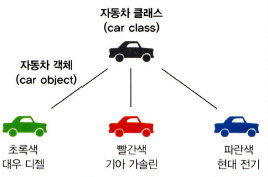

객체(object) : 메모리를 할당받아 프로그램에서 사용되는 모든 데이터. 변수, 함수
```
객체명=클래스명()
```

**클래스와 함수**
* 함수 : 하나의 특정 작업을 수행하기 위해 독립적으로 설계된 프로그램. 함수의 호출은 특정 작업만 수행할 뿐 그 결괏값을 계속 사용하기 위해서는 반드시 어딘가에 따로 그 값을 저장해야 한다. 즉, 함수를 포함한 프로그램 코드의 일부를 재사용하기 위해서는 해당 함수뿐만 아니라 데이터가 저장되는 변수까지도 한꺼번에 관리해야 한다.
* 클래스 : 함수뿐만 아니라 관련된 변수까지도 한꺼번에 묶어서 관리하고 재사용할 수 있게 해주는 것

In [ ]:
# 함수
def add(num1, num2):
  result=num1+num2
  return result

print(add(1, 2))
print(add(2, 3))

3
5


In [ ]:
# 클래스
class Calc:
  def __init__(self): ## 객체를 생성할 때 호출하면 실행되는 초기화 함수
    self.result=0

  def add(self, num1, num2):
    self.result=num1+num2
    return self.result

obj1=Calc()
obj2=Calc()

print(obj1, add(1, 2))
print(obj1, add(2, 3))
print('----------------------')
print(obj2, add(2, 2))
print(obj2, add(2, 3))

<__main__.Calc object at 0x7969db2f27a0> 3
<__main__.Calc object at 0x7969db2f27a0> 5
----------------------
<__main__.Calc object at 0x7969db2f2980> 4
<__main__.Calc object at 0x7969db2f2980> 5


순전파 연산 : $H(x)$ 식에 입력된 x로부터 예측된 y를 얻는 연산
  * $H(x)=sigmoid(x_1w_1+x_2w_2+b)$ : 활성화 함수 및 입력 값에 따라 다르다.

활성화 함수 지정 방법
1. `F.relu()` : `forward()` 함수에서 정의 (`nn.functional.xx()`와 동일)
2. `nn.ReLU()` : `__init__()` 함수에서 정의

In [ ]:
## 활성화 함수 지정 : nn 사용
import torch
import torch.nn as nn

inputs=torch.randn(64, 3, 244, 244)
conv=nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
## 3개의 채널이 입력되어 64개의 채널이 출력되기 위한 연산으로 3x3 크기의 커널 사용
outputs=conv(inputs)
layer=nn.Conv2d(1, 1, 3)

In [ ]:
## 활성화 함수 지정 : nn.functional 사용
import torch.nn.functional as F

inputs=torch.randn(64, 3, 244, 244)
weight=torch.randn(64, 3, 3, 3)
bias=torch.randn(64)
outputs=F.conv2d(inputs, weight, bias, padding=1)

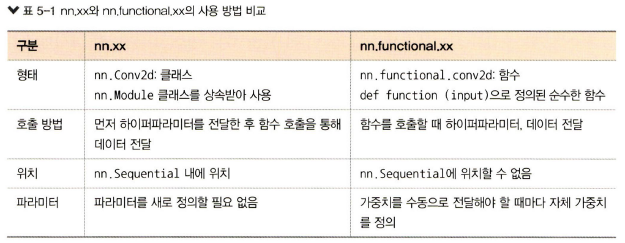

In [ ]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate=0.001;
model=FashionDNN();
model.to(device)

criterion=nn.CrossEntropyLoss(); ## 분류 문제에서 사용하는 손실 함수
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate); ## 옵티마이저를 위한 경사 하강법으로 Adam 사용
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# 심층 신경망을 이용한 모델 학습
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
  for images, labels in train_loader:
    ## for 구문을 사용하여 레코드(행, 가로줄)를 하나씩 가져온다.
    ## for x, y in train: : in 앞에 변수 두 개를 지정해 주면 레코드에서 요소 두 개를 꺼내 오겠다는 의미이다.
    images, labels=images.to(device), labels.to(device)
    ## 심층 신경망에서 필요한 파라미터 정의에서 model.to(device)가 GPU를 사용했다면,
    ## images.to(device), labels.to(device)도 GPU에서 처리되어야 한다.

    train=Variable(images.view(100, 1, 28, 28))
    labels=Variable(labels)
    ## Autograd : 자동 미분을 수행하는 패키지. 자동 미분에 대한 값을 저장하기 위해 테이프를 사용한다.
    ## 순전파 단계에서 테이프는 수행하는 모든 연산을 저장한다.
    ## 역전파 단계에서 저장된 값을 사용한다.
    ## Autograd는 Variable을 사용해서 역전파를 위한 미분 값을 자동으로 계산해 준다.
    ## 자동 미분을 계산하기 위해서는 torch.autograd 패키지의 Variable을 사용해야 동작한다.

    outputs=model(train) ## 학습 데이터를 모델에 적용
    loss=criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count+=1

    if not (count % 50): ## count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total=0
      correct=0
      for images, labels in test_loader:
        images, labels=images.to(device), labels.to(device)
        labels_list.append(labels)
        test=Variable(images.view(100, 1, 28, 28))
        outputs=model(test)
        predictions=torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct+=(predictions==labels).sum()
        total+=len(labels)

      accuracy=correct*100/total ## 분류 문제에 대한 정확도는 전체 예측에 대한 정확한 예측의 비율로 표현할 수 있다.
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print('Iteration : {}, loss : {}, Accuracy : {}%'.format(count, loss.data, accuracy))

Iteration : 500, loss : 0.5713228583335876, Accuracy : 83.2699966430664%
Iteration : 1000, loss : 0.4681400656700134, Accuracy : 84.5%
Iteration : 1500, loss : 0.36565861105918884, Accuracy : 84.77999877929688%
Iteration : 2000, loss : 0.3642635643482208, Accuracy : 85.61000061035156%
Iteration : 2500, loss : 0.2565983831882477, Accuracy : 86.41999816894531%
Iteration : 3000, loss : 0.27528828382492065, Accuracy : 86.93000030517578%


최종 정확도 : 87.31999969482422%

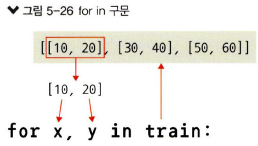

정확도
* classification accuracy=correct predictions/total predictions
* classification accuracy=correct predictions/total predictions*100
* error rate=(1-correct predictions/total predictions))*100

* 정확도가 80% 이상 : 80%라는 값이 모든 클래스가 동등히 고려된 것인지, 특정 클래스의 분류가 높았던 것인지에 대해 알 수 없다.
* 정확도가 90% 이상 : 100개의 데이터 중 90개가 하나의 클래스에 속할 경우, 90%의 정확도는 높다고 할 수 없다. 즉, 모든 데이터를 특정 클래스에 속한다고 예측해도 90% 예측 결과가 나오기 때문에 데이터 특성에 따라 정확도를 잘 관측해야 한다.

In [ ]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1=nn.Sequential(
        ## nn.Sequential : __init__()에서 사용할 네트워크 모델을 정의해 줌.
        ## forward() 함수에서 구현될 순전파를 계층 형태로 좀 더 가독성이 뛰어난 코드로 작성할 수 있음.
        ## 계층을 차례로 쌓을 수 있도록 Wx+b와 같은 수식과 활성화 함수를 연결해 주는 역할을 함.
        ## 데이터가 각 계층을 순차적으로 지나갈 때 사용.
        ## 여러 개의 계층을 하나의 컨테이너에 구현하는 방법.

        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        ## in_channels : 입력 채널 수. 흑백 이미지는 1, RGB 값을 가진 이미지는 3
        ## out_channels : 출력 채널 수
        ## kernel_size : 커널 크기 or 필터. kernel_size=3일 때 커널의 크기는 (3, 3)이고, 직사각형을 사용하고 싶으면 (3, 5)와 같이 따로 지정해야 함.
        ## padding : 패딩 크기. 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채움. 패딩 값이 클수록 출력 크기도 커짐.

        nn.BatchNorm2d(32), ## 정규화
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) ## 이미지 크기 축소
        ## kernel_size : mxn 행렬로 구성된 가중치
        ## stride : 입력 데이터에 커널(필터)을 적용할 때 이동할 간격. 스트라이드 값이 커지면 출력 크기는 작아짐.
    )
    self.layer2=nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1=nn.Linear(in_features=64*6*6, out_features=600)
    ## in_features : 입력 데이터의 크기
    ## out_features : 출력 데이터의 크기

    self.drop=nn.Dropout2d(0.25)
    self.fc2=nn.Linear(in_features=600, out_features=120)
    self.fc3=nn.Linear(in_features=120, out_features=10) ## 마지막 계층의 out_features는 클래스의 개수 의미

  def forward(self, x):
    out=self.layer1(x)
    out=self.layer2(out)
    out=out.view(out.size(0), -1)
    ## 합성곱층에서 완전연결층으로 변경되기 때문에 데이터의 형태를 1차원으로 바꿈.
    ## out.sizer(0) : 100

    out=self.fc1(out)
    out=self.drop(out)
    out=self.fc2(out)
    out=self.fc3(out)
    return out

**채널**

2D 합성곱층에 이미지를 적용한다고 가정
1. 흑백 이미지 : 이미지 데이터는 $w\times{h}$(너비x높이) 형태의 행렬로 표현된다.
2. 컬러 이미지 : Red, Green, Blue 세 채널을 가지고 있음. $w\times{h}\times{c}$(c : 채널 수) 형태의 행렬로 표현할 수 있음. 3차원으로 생각하면 채널은 결국 깊이(depth)를 의미함.

**BatchNorm2d** : 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것. 배치 단위나 계층에 따라 입력 값의 분포가 모두 다르지만 정규화를 통해 분포를 가우시안 형태로 만든다. 평균 0, 표준편차 1로 데이터의 분포가 조절됨.

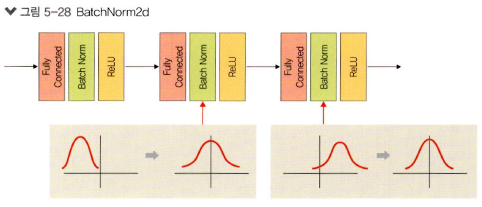

**MaxPool2d** : 이미지 크기 축소. 풀링 계층은 합성곱층의 출력 데이터를 입력으로 받아서 출력 데이터의 크기를 줄이거나 특정 데이터를 강조하는 용도로 사용된다. 풀링 계층을 처리하는 방법으로는 최대 풀링, 평균 풀링, 최소 풀링이 있다.

**Conv2d 계층에서의 출력 크기 구하는 공식**

* $출력 크기=(W-F+2P)/S+1$
  * W : 입력 데이터의 크기(`input_volume_size)
  * F : 커널 크기(`kernel_size`)
  * P : 패딩 크기(`padding_size`)
  * S : 스트라이드(`strides`)

  ```
  nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
  ```
  출력 크기 : $(784-3+(2\times1))/1+1=784$
  (fashion_mnist의 입력 데이터 크기는 784이며, stride가 명시되어 있지 않다면 stride 기본값은 (1, 1)이다.)

  출력의 형태 [32, 784, 784]

**MaxPool2d 계층에서의 출력 크기 구하는 공식**

* $출력 크기=IF/F$
  * IF : 입력 필터의 크기(`input_filter_size`, Conv2d의 출력 크기)
  * F : 커널 크기(`kernel_size`)
  ```
  nn.MaxPool2d(kernel_size=2, stride=2)
  ```
  
  출력 크기 : $784/2=392$
  (784는 첫 번째 Conv2d에서 계산한 결과)
  
  출력의 형태 [32, 392, 392]

In [ ]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate=0.001;
model=FashionCNN();
model.to(device)

criterion=nn.CrossEntropyLoss();
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
# 모델 학습 및 성능 평가
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]

predictions_list=[]
labels_list=[]

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels=images.to(device), labels.to(device)

    train=Variable(images.view(100, 1, 28, 28))
    labels=Variable(labels)

    outputs=model(train)
    loss=criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count+=1

    if not (count % 50):
      total=0
      correct=0
      for images, labels in test_loader:
        images, labels=images.to(device), labels.to(device)
        labels_list.append(labels)
        test=Variable(images.view(100, 1, 28, 28))
        outputs=model(test)
        predictions=torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions==labels).sum()
        total += len(labels)

      accuracy=correct*100/total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print('Iteration : {}, loss : {}, Accuracy : {}%'.format(count, loss.data, accuracy))

Iteration : 500, loss : 0.4592566192150116, Accuracy : 87.83000183105469%
Iteration : 1000, loss : 0.2910287380218506, Accuracy : 89.16000366210938%
Iteration : 1500, loss : 0.2862337827682495, Accuracy : 87.9000015258789%
Iteration : 2000, loss : 0.20979422330856323, Accuracy : 88.66999816894531%
Iteration : 2500, loss : 0.12219317257404327, Accuracy : 89.41000366210938%
Iteration : 3000, loss : 0.16338594257831573, Accuracy : 90.95999908447266%


90.95999908447266%

심층 신경망과 비교하여 정확도가 약간 높다. 실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가하므로 합성곱 신경망을 생성할 수 있도록 학습해야 한다.